In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable

# load data

In [2]:
import json
import numpy as np
from PIL import Image

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                            std=[0.5, 0.5, 0.5])
                   ])),
    batch_size=256, num_workers=2, shuffle=False)

(-0.5, 132.5, 132.5, -0.5)

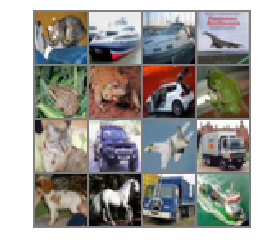

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
%matplotlib inline

def imshow(img):
    # unnormalize [-1, 1] => [0, 1]
    img = img / 2 + 0.5
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

x, y = iter(train_loader).next()
x, y = x[:16], y[:16]
imshow(make_grid(x, nrow=4, padding=1))
plt.axis('off')

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.Resize(256),
                       transforms.CenterCrop(224),
                       transforms.ToTensor(),
                       normalize
                   ])),
    batch_size=64, num_workers=2, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False,
                   transform=transforms.Compose([
                       transforms.Resize(256),
                       transforms.CenterCrop(224),
                       transforms.ToTensor(),
                       normalize
                   ])),
    batch_size=64, num_workers=2, shuffle=True)

# train

## pretreined

In [3]:
model = models.vgg16(pretrained=True)
model.cuda()
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    

In [14]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

img = Image.open('./data/cat.jpg')
img_tensor = preprocess(img)
print(img_tensor.shape)

torch.Size([3, 224, 224])


In [15]:
img_tensor.unsqueeze_(0)
print(img_tensor.size())

torch.Size([1, 3, 224, 224])


In [16]:
pred = vgg16(Variable(img_tensor).cuda())
print(pred.size())

torch.Size([1, 1000])


In [26]:
pred.topk(5)

(Variable containing:
  18.7358  17.9395  17.3104  14.7489  10.0150
 [torch.cuda.FloatTensor of size 1x5 (GPU 0)], Variable containing:
  285  281  282  287  283
 [torch.cuda.LongTensor of size 1x5 (GPU 0)])

In [38]:
class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
class_index['285']

['n02124075', 'Egyptian_cat']

## implementation

In [27]:
class VGG(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU(True))
        self.conv5 = nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(True))
        self.conv6 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True))
        self.conv7 = nn.Sequential(nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True))
        self.conv8 = nn.Sequential(nn.Conv2d(256, 512, 3, 1, 1), nn.ReLU(True))
        self.conv9 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True))
        self.conv10 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True))
        self.conv11 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True))
        self.conv12 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True))
        self.conv13 = nn.Sequential(nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True))
        
        self.pool1 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))
        self.pool2 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))
        self.pool3 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))
        self.pool4 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))
        self.pool5 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.classifier = nn.Sequential(nn.Linear(in_features=25088,
                                                  out_features=4096),
                                        nn.ReLU(True),
                                        nn.Dropout(),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(True),
                                        nn.Dropout(),
                                        nn.Linear(4096, num_classes)
                                       )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)

        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool4(x)

        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [28]:
model = VGG().cuda()
model

VGG(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (conv5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (conv6): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (conv7): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (conv8): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReL

In [29]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

def train(train_loader):
    model.train()
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.cuda(), y.cuda()
        b_x = Variable(x)
        b_y = Variable(y)
        
        optimizer.zero_grad()
        outputs = model(b_x)
        
        loss = loss_func(outputs, b_y)
        train_loss += loss.data[0]

        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(train_loader)
    
    return train_loss

def valid(test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()
        b_x = Variable(x, volatile=True)
        b_y = Variable(y, volatile=True)
        
        outputs = model(b_x)
        loss = loss_func(outputs, b_y)
        test_loss += loss.data[0]
        
        pred = outputs.data.max(1, keepdim=True)[1]
        correct += pred.eq(b_y.data.view_as(pred)).cpu().sum()
        total += b_y.size(0)

    val_loss = test_loss / len(test_loader)
    val_acc = correct / total
    
    return val_loss, val_acc

In [30]:
epochs = 1
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(epochs):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)

    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 6.8527 val_loss: 6.7981 val_acc: 0.1000
